### Import Libraries

In [80]:
# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Financial Data Analysis
import yfinance as yf
import ta
import quantstats as qs

# Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

### Load and Prepare Data 

In [81]:
df = pd.read_csv('btc_2015_2024.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close
date,,,,,,,,,,,,,,,,,,,
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650.0,100.000000,100.000000,-66.666667,-66.666667,314.640503,314.648333,314.640503,314.644418,0.017568,314.640503,2.273987,4.193073,4.275997,281.082001
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400.0,1.938583,2.096744,-100.000000,-100.000000,303.454336,303.009081,303.454336,303.232458,-1.030403,303.454336,34.067993,15.719617,14.951008,264.195007
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100.0,1.235506,1.375421,-110.693896,-110.693896,293.639503,292.715747,293.639503,293.178382,-2.091487,293.639503,29.618011,20.033779,19.034849,274.473999
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800.0,21.462825,19.523695,-76.487357,-76.487357,289.806403,288.769813,289.806403,289.286389,-2.215008,289.806403,14.145996,18.468441,17.907070,286.188995
2015-01-06,274.610992,287.553009,272.696014,286.188995,23245700.0,38.272356,34.350787,-37.070244,-37.070244,289.203501,288.295540,289.203501,288.744005,-1.746686,289.203501,14.856995,17.613461,17.300126,294.337006


In [82]:
### Data Preprocessing

In [83]:
df.columns = df.columns.str.lower()
del df['next_day_close']

df_copy = df.copy()

In [84]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3406 entries, 2015-01-02 to 2024-04-29
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       3406 non-null   float64
 1   high       3406 non-null   float64
 2   low        3406 non-null   float64
 3   close      3406 non-null   float64
 4   volume     3406 non-null   float64
 5   rsi_7      3406 non-null   float64
 6   rsi_14     3406 non-null   float64
 7   cci_7      3406 non-null   float64
 8   cci_14     3406 non-null   float64
 9   sma_50     3406 non-null   float64
 10  ema_50     3406 non-null   float64
 11  sma_100    3406 non-null   float64
 12  ema_100    3406 non-null   float64
 13  macd       3406 non-null   float64
 14  bollinger  3406 non-null   float64
 15  truerange  3406 non-null   float64
 16  atr_7      3406 non-null   float64
 17  atr_14     3406 non-null   float64
dtypes: float64(18)
memory usage: 505.6 KB


### Visualization: BTC Price History

In [85]:
# candlestick chart for btc
candlestick = go.Candlestick(x=df.index, 
                             open=df['open'], 
                             high=df['high'], 
                             low=df['low'], 
                             close=df['close'], 
                             increasing=dict(line=dict(color='green')), 
                             decreasing=dict(line=dict(color='red')),
                             showlegend=False)

layout = go.Layout(
    title='BTC 2015-2024 Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template = 'ggplot2',
    xaxis_rangeslider_visible=False,
    yaxis_gridcolor='white',
    xaxis_gridcolor='white',
    yaxis_tickfont=dict(color='black'),
    xaxis_tickfont=dict(color='black'),
    margin=dict(t=50,l=50,r=50,b=50)
)

fig = go.Figure(data=[candlestick], layout=layout)
fig.show()


In [86]:
# as we can see in the chart, the price of BTC has been volatile over the years, but as it shows, the major trend is upwards.

### Feature Engineering

In [87]:
def feature_engineering(df):
    # rsi
    df['rsi_14_overbought'] = (df['rsi_14'] >= 70).astype(int)
    df['rsi_14_oversold'] = (df['rsi_14'] <= 30).astype(int)
    df['rsi_7_overbought'] = (df['rsi_7'] >= 70).astype(int)
    df['rsi_7_oversold'] = (df['rsi_7'] <= 30).astype(int)
    # cci
    df['cci_7_high'] = (df['cci_7'] >= 100).astype(int)
    df['cci_7_low'] = (df['cci_7'] <= -100).astype(int)
    df['cci_14_high'] = (df['cci_14'] >= 100).astype(int)
    df['cci_14_low'] = (df['cci_14'] <= -100).astype(int)
    # macd
    macd = ta.trend.MACD(df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    df['macd_above'] = (df['macd_diff'] > 0).astype(int)
    df['macd_below'] = (df['macd_diff'] < 0).astype(int)
    df['macd_cross_above'] = (df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))
    df['macd_cross_below'] = (df['macd'] < df['macd_signal']) & (df['macd'].shift(1) >= df['macd_signal'].shift(1))

    return df
df = feature_engineering(df)

### Train-Test Split

In [88]:
df_full_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle=False)

In [89]:
print(df_train.index[0], df_train.index[-1])
print(df_val.index[0], df_val.index[-1])
print(df_test.index[0], df_test.index[-1])

2015-01-02 00:00:00 2020-08-05 00:00:00
2020-08-06 00:00:00 2022-06-17 00:00:00
2022-06-18 00:00:00 2024-04-29 00:00:00


### Calculate returns and add it to the dataframe

In [90]:
# Add close shift variable

df_train['prev_close'] = df_train['close'].shift(1)
df_val['prev_close'] = df_val['close'].shift(1)
df_test['prev_close'] = df_test['close'].shift(1)

# Add daily return variable
df_train['return'] = (df_train['close'] / df_train['prev_close'] - 1) * 100
df_val['return'] = (df_val['close'] / df_val['prev_close'] - 1) * 100
df_test['return'] = (df_test['close'] / df_test['prev_close'] - 1) * 100

In [91]:
df_train

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,...,cci_14_high,cci_14_low,macd_signal,macd_diff,macd_above,macd_below,macd_cross_above,macd_cross_below,prev_close,return
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,314.079010,315.838989,313.565002,315.032013,7.860650e+06,100.000000,100.000000,-66.666667,-66.666667,314.640503,...,0,0,NaN,NaN,0,0,False,False,NaN,NaN
2015-01-03,314.846008,315.149994,281.082001,281.082001,3.305440e+07,1.938583,2.096744,-100.000000,-100.000000,303.454336,...,0,1,NaN,NaN,0,0,False,False,315.032013,-10.776686
2015-01-04,281.145996,287.230011,257.612000,264.195007,5.562910e+07,1.235506,1.375421,-110.693896,-110.693896,293.639503,...,0,1,NaN,NaN,0,0,False,False,281.082001,-6.007853
2015-01-05,265.084015,278.341003,265.084015,274.473999,4.396280e+07,21.462825,19.523695,-76.487357,-76.487357,289.806403,...,0,0,NaN,NaN,0,0,False,False,264.195007,3.890684
2015-01-06,274.610992,287.553009,272.696014,286.188995,2.324570e+07,38.272356,34.350787,-37.070244,-37.070244,289.203501,...,0,0,NaN,NaN,0,0,False,False,274.473999,4.268162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,11322.570313,11794.775391,11239.682617,11759.592773,2.607567e+10,94.726697,87.613765,122.674403,118.589777,9545.017988,...,1,0,324.943440,226.336981,1,0,False,False,11323.466797,3.851523
2020-08-02,11758.764648,12034.144531,11018.129883,11053.614258,2.741007e+10,62.180165,66.929482,67.509494,85.033648,9576.584726,...,0,0,369.039363,176.383694,1,0,False,False,11759.592773,-6.003427
2020-08-03,11043.768555,11453.079102,11012.415039,11246.348633,2.027171e+10,65.910652,69.075915,8.709987,65.371193,9613.775937,...,0,0,405.230117,144.763014,1,0,False,False,11053.614258,1.743632


### Create Target Variable

This is used to predict whether the price will go up (1) or down (0) the next day based on the features available for the current day.

In [92]:
df_train['target'] = np.where(df_train['return'].shift(-1) > 0, 1, 0)
df_val['target'] = np.where(df_val['return'].shift(-1) > 0, 1, 0)
df_test['target'] = np.where(df_test['return'].shift(-1) > 0, 1, 0)

In [93]:
df_train[['close', 'prev_close', 'return', 'target']]

,close,prev_close,return,target
date,,,,
2015-01-02,315.032013,NaN,NaN,0
2015-01-03,281.082001,315.032013,-10.776686,0
2015-01-04,264.195007,281.082001,-6.007853,1
2015-01-05,274.473999,264.195007,3.890684,1
2015-01-06,286.188995,274.473999,4.268162,1
...,...,...,...,...
2020-08-01,11759.592773,11323.466797,3.851523,0
2020-08-02,11053.614258,11759.592773,-6.003427,1
2020-08-03,11246.348633,11053.614258,1.743632,0


In [94]:
X_train = df_train.drop(columns=['target'])
X_val = df_val.drop(columns=['target'])
X_test = df_test.drop(columns=['target'])

y_train = df_train['target']
y_val = df_val['target']
y_test = df_test['target']

In [95]:
X_train.shape

(2043, 34)

In [96]:
X_test

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,...,cci_14_high,cci_14_low,macd_signal,macd_diff,macd_above,macd_below,macd_cross_above,macd_cross_below,prev_close,return
date,,,,,,,,,,,,,,,,,,,,,
2022-06-18,20473.425781,20736.041016,17708.623047,19017.642578,4.200944e+10,10.825853,20.184289,-111.200535,-115.517063,30090.244727,...,0,1,-1949.194714,-932.457981,0,1,False,False,NaN,NaN
2022-06-19,19010.902344,20683.822266,18067.152344,20553.271484,3.532994e+10,27.445747,28.387883,-82.863194,-89.269036,29747.012656,...,0,0,-2147.619081,-793.697470,0,1,False,False,19017.642578,8.074760
2022-06-20,20553.371094,20913.322266,19689.169922,20599.537109,3.081846e+10,27.917957,28.625903,-25.849484,-69.795117,29389.621523,...,0,0,-2308.265616,-642.586140,0,1,False,False,20553.271484,0.225101
2022-06-21,20594.294922,21620.628906,20415.062500,20710.597656,2.897021e+10,29.208293,29.233951,35.832109,-54.854414,29033.246914,...,0,0,-2429.779471,-486.055417,0,1,False,False,20599.537109,0.539141
2022-06-22,20719.414063,20835.750000,19848.078125,19987.029297,2.857479e+10,25.710083,27.585119,-13.523546,-61.150539,28677.978438,...,0,0,-2526.401913,-386.489771,0,1,False,False,20710.597656,-3.493711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25,64275.019531,65275.207031,62783.632813,64481.707031,3.215579e+10,44.648873,46.387439,-56.342372,-19.542900,67492.101953,...,0,0,-552.081033,-83.624368,0,1,False,False,64276.898438,0.318635
2024-04-26,64485.371094,64789.656250,63322.398438,63755.320313,2.413937e+10,40.732452,44.690989,-97.744291,-20.566277,67428.698672,...,0,0,-582.818856,-122.951293,0,1,False,False,64481.707031,-1.126500
2024-04-27,63750.988281,63898.363281,62424.718750,63419.140625,1.953078e+10,38.890523,43.890963,-117.618281,-62.695061,67331.079610,...,0,0,-622.142879,-157.296092,0,1,False,False,63755.320313,-0.527297


In [97]:
X_train_full = pd.concat([df_train, df_val]).drop(columns=['target'])
X_test_full = df_test.drop(columns=['target'])

y_train_full = pd.concat([df_train['target'], df_val['target']])
y_test_full = df_test['target']

In [98]:
print(X_train_full.shape[0], X_test_full.shape[0])
print(y_train_full.shape[0], y_test_full.shape[0])

2724 682
2724 682


In [99]:
print(len(X_train), len(X_val), len(X_test))
print(len(y_train), len(y_val), len(y_test))

2043 681 682
2043 681 682


### Handle Missing Values

In [100]:
X_train = X_train.dropna()
X_val = X_val.dropna()
X_test = X_test.dropna()

y_train = y_train[X_train.index]
y_val = y_val[X_val.index]
y_test = y_test[X_test.index]

X_train_full = X_train_full.dropna()
X_test_full = X_test_full.dropna()

y_train_full = y_train_full[X_train_full.index]
y_test_full = y_test_full[X_test_full.index]

In [101]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2010, 34) (680, 34) (681, 34)
(2010,) (680,) (681,)


In [102]:
print('3 Way Split Without Null Values')
print(len(X_train), len(X_val), len(X_test))
print(len(y_train), len(y_val), len(y_test))
print()
print('2 Way Split Without Null Values')
print(len(X_train_full), len(X_test_full))
print(len(y_train_full), len(y_test_full))


3 Way Split Without Null Values
2010 680 681
2010 680 681

2 Way Split Without Null Values
2690 681
2690 681


In [103]:
X_train.columns

Index(['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7',
       'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger',
       'truerange', 'atr_7', 'atr_14', 'rsi_14_overbought', 'rsi_14_oversold',
       'rsi_7_overbought', 'rsi_7_oversold', 'cci_7_high', 'cci_7_low',
       'cci_14_high', 'cci_14_low', 'macd_signal', 'macd_diff', 'macd_above',
       'macd_below', 'macd_cross_above', 'macd_cross_below', 'prev_close',
       'return'],
      dtype='object')

### Comparison of Different Models

In [104]:
# Creating a list of different classification models 
classifiers = [
    LogisticRegression(random_state = 1),
    XGBClassifier(random_state = 1),
    RandomForestClassifier(random_state = 1)
]

#  Iterating over classifiers in the list above, training, and evaluating them
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.491
XGBClassifier: AUC Score=0.499


RandomForestClassifier: AUC Score=0.534


### Try XGBClassifier

In [105]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

### Feature Importance Analysis

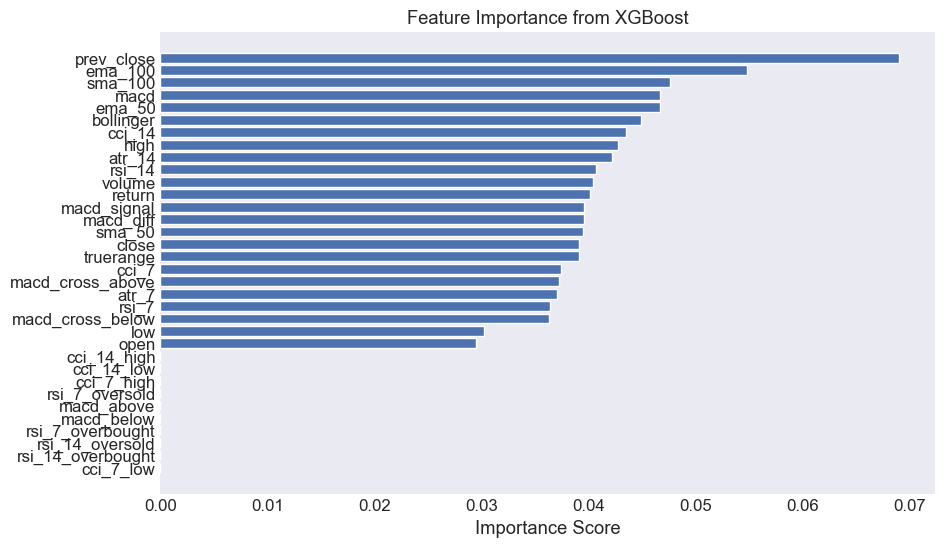

In [106]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

### Identify the best features


In [107]:
# import random
# from sklearn.metrics import roc_auc_score
# from xgboost import XGBClassifier

# def evaluate_random_feature_combinations_fulltrain(X_train, y_train, X_test, y_test, features, iterations=10000):
#     max_auc_score = 0
#     max_features = []

#     for _ in range(iterations):
#         # randomly selects a number of features from 1 to 30
#         num_features = random.randint(1, 30)
#         selected_features = random.sample(features, num_features)
        
#         # train the model with the selected features
#         xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
#         xgb_model.fit(X_train[selected_features], y_train)
        
#         # calculate auc
#         y_pred = xgb_model.predict_proba(X_test[selected_features])[:, 1]
#         auc_score = roc_auc_score(y_test, y_pred)
        
#         # update max_auc_score and max_features if current auc_score is higher
#         if auc_score > max_auc_score:
#             max_auc_score = auc_score
#             max_features = selected_features
    
#     return max_features, max_auc_score

# features = [
#     'open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7',
#     'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger',
#     'truerange', 'atr_7', 'atr_14', 'rsi_14_overbought', 'rsi_14_oversold',
#     'rsi_7_overbought', 'rsi_7_oversold', 'cci_7_high', 'cci_7_low',
#     'cci_14_high', 'cci_14_low', 'macd_signal', 'macd_diff', 'macd_above',
#     'macd_below', 'macd_cross_above', 'macd_cross_below'
# ]

# max_features, max_auc_score = evaluate_random_feature_combinations_fulltrain(X_train_full, y_train_full, X_test_full, y_test_full, features)

# # print the maximum auc score and corresponding features
# print(f"Max AUC: {max_auc_score:.3f}")
# print(f"Features: {max_features}")

In [108]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(2010, 34) (680, 34) (681, 34)
(2010,) (680,) (681,)


In [109]:
# adjusted columns
selected_features = ['rsi_7_oversold', 'macd_below', 'sma_100', 'rsi_14', 'ema_100', 'cci_14_high', 'rsi_7_overbought', 'macd_above', 'cci_14_low', 'rsi_14_oversold']

In [110]:
X_train[selected_features].iloc[1000]

rsi_7_oversold         0.000000
macd_below             0.000000
sma_100             4301.185491
rsi_14                71.952402
ema_100             4405.677023
cci_14_high            1.000000
rsi_7_overbought       1.000000
macd_above             1.000000
cci_14_low             0.000000
rsi_14_oversold        0.000000
Name: 2017-10-31 00:00:00, dtype: float64

In [111]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=1)
xgb_model.fit(X_train[selected_features], y_train)
y_pred = xgb_model.predict_proba(X_val[selected_features])[:,1]
auc_score = roc_auc_score(y_val, y_pred)
print(f'XGBoost: AUC Score={auc_score:.3f}')

XGBoost: AUC Score=0.587


In [112]:
y_train.iloc[1000]

1

### Create AUC-ROC Curve in Comparison with Random Guess

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


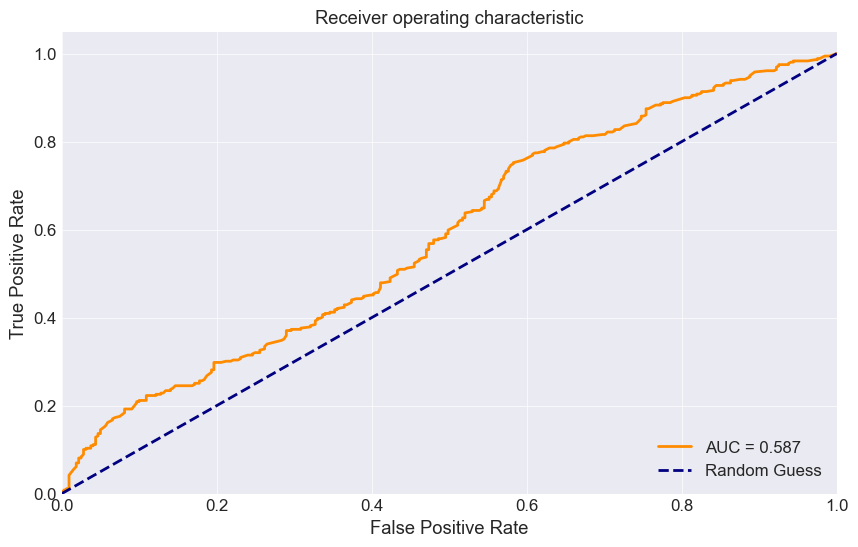

In [113]:
# Check available styles
print(plt.style.available)

# Plotting AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.style.use('seaborn-v0_8-dark')
plt.grid(True)
plt.show()

### Compare AUC Scores of Training and Validation Sets

[0]	validation_0-auc:0.66723	validation_1-auc:0.53547
[1]	validation_0-auc:0.68550	validation_1-auc:0.54388


[2]	validation_0-auc:0.70555	validation_1-auc:0.54027
[3]	validation_0-auc:0.72089	validation_1-auc:0.54021
[4]	validation_0-auc:0.72918	validation_1-auc:0.53068
[5]	validation_0-auc:0.74090	validation_1-auc:0.50893
[6]	validation_0-auc:0.75207	validation_1-auc:0.52579
[7]	validation_0-auc:0.75766	validation_1-auc:0.52579
[8]	validation_0-auc:0.76717	validation_1-auc:0.52858
[9]	validation_0-auc:0.76909	validation_1-auc:0.54007
[10]	validation_0-auc:0.77462	validation_1-auc:0.54007
[11]	validation_0-auc:0.79237	validation_1-auc:0.55214
[12]	validation_0-auc:0.79945	validation_1-auc:0.55180
[13]	validation_0-auc:0.80846	validation_1-auc:0.56506
[14]	validation_0-auc:0.81119	validation_1-auc:0.56506
[15]	validation_0-auc:0.81312	validation_1-auc:0.56398
[16]	validation_0-auc:0.81590	validation_1-auc:0.56733
[17]	validation_0-auc:0.82154	validation_1-auc:0.56363
[18]	validation_0-auc:0.82508	validation_1-auc:0.56228
[19]	validation_0-auc:0.83254	validation_1-auc:0.56519
[20]	validation_0-

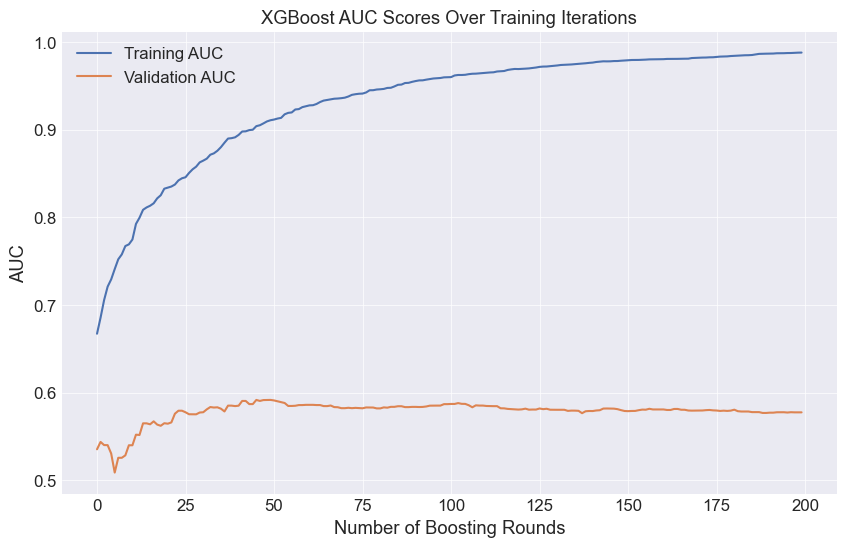

Initial Highest Training AUC: 0.988
Initial Highest Validation AUC: 0.592
Final gap: 0.4101


In [114]:
# Define the evaluation sets
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    eta=0.3,
    max_depth=6,
    min_child_weight=1,
    objective='binary:logistic',
    n_jobs=8,
    random_state=1,
    verbosity=1,
    n_estimators=200,
)

xgb_model.fit(
    X_train_selected, 
    y_train,
    eval_set=[(X_train_selected, y_train), (X_val_selected, y_val)],
)

# get evaluation results
results = xgb_model.evals_result()

# plot results
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['auc'], label='Training AUC')
plt.plot(results['validation_1']['auc'], label='Validation AUC')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('AUC')
plt.title('XGBoost AUC Scores Over Training Iterations')
plt.legend()
plt.grid(True)
plt.show()

# print scores
print(f"Initial Highest Training AUC: {max(results['validation_0']['auc']):.3f}")
print(f"Initial Highest Validation AUC: {max(results['validation_1']['auc']):.3f}")

# gap between training and validation
train_auc = results['validation_0']['auc'][-1]
val_auc = results['validation_1']['auc'][-1]
print(f"Final gap: {train_auc - val_auc:.4f}")

### Function to Train XGBoost Model

In [115]:
def train_xgboost_model(X_train_selected, y_train, X_val_selected, y_val, params=None):
    # default parameters
    default_params = {
        'eval_metric': 'auc',
        'eta': 0.3,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'n_jobs': 8,
        'random_state': 1,
        'verbosity': 1,
        'seed': 1,
        'n_estimators': 500,
        'verbosity': 1
    }
    
    # update default params with custom params if provided
    if params:
        default_params.update(params)
    
    xgb_model = XGBClassifier(**default_params)
    
    # fit model
    xgb_model.fit(
        X_train_selected, 
        y_train,
        eval_set=[(X_train_selected, y_train), (X_val_selected, y_val)],
    )
    
    # get evaluation results
    results = xgb_model.evals_result()
    
    return xgb_model, results

### Convert XGBoost results into a DataFrame for plotting 

In [116]:
def parse_xgb_output(results):
    train_auc = results['validation_0']['auc']
    val_auc = results['validation_1']['auc']
    
    return pd.DataFrame({
        'num_iter': range(len(train_auc)),
        'train_auc': train_auc,
        'val_auc': val_auc
    })

### Model Tuning: Learning Rate (eta)

In [117]:
scores = {}

In [118]:
%%capture output

for max_eta in [0.3, 0.7]:
    params = {
        'eta': max_eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': 8,
        'random_state': 1,
        'verbosity': 1,
        'n_estimators': 200
    }
    
    # Train model
    model, results = train_xgboost_model(X_train_selected, y_train, X_val_selected, y_val, params)
    
    # Store results
    key = f'max_eta={max_eta}'
    scores[key] = parse_xgb_output(results)

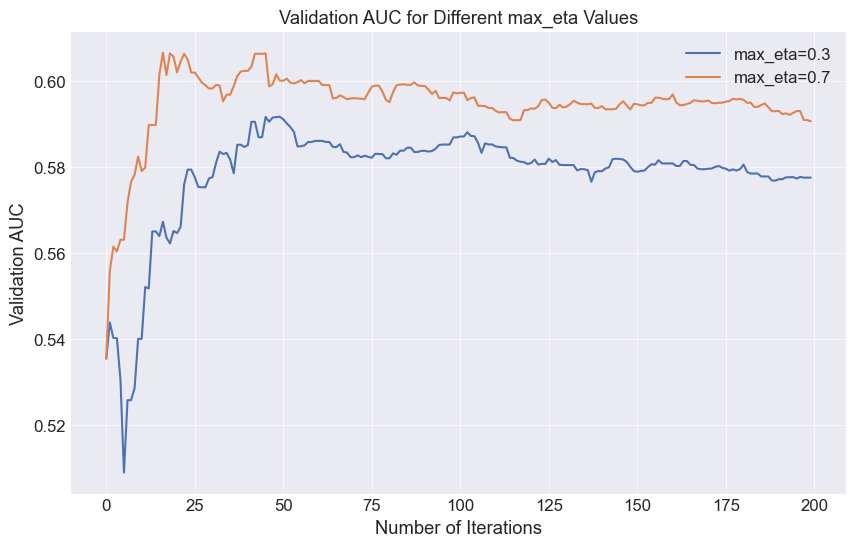

In [119]:
# plot results
plt.figure(figsize=(10, 6))
for max_eta, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=max_eta)

plt.xlabel('Number of Iterations')
plt.ylabel('Validation AUC')
plt.title('Validation AUC for Different max_eta Values')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# 0.3 and 0.7 shows the best performance for eta. 0.3 takes a bit longer to converge 
# like 50 iterations to reach similar performance as 0.7. while 0.7 reaches a higher auc score which 
# shows that it is more likely to overfit

# eta=0.7 (red line):
# - Shows more volatility
# - Steeper drops in performance
# - More aggressive learning
# eta=0.3 (orange line):
# - More stable learning curve
# - Smoother performance
# - More gradual adjustments

# higher eta overfits:
# - Takes larger steps in optimization
# - More likely to "jump over" optimal solutions
# - Can overreact to noise in the training data
# - Makes more dramatic adjustments to each tree

### Model Tuning: Tree Depth

In [121]:
scores = {}

In [122]:
%%capture output

for max_depth in [3, 6, 7]:
    params = {
        'eta': 0.3,
        'max_depth': max_depth,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': 8,
        'random_state': 1,
        'verbosity': 1,
        'n_estimators': 200
    }
    
    # Train model
    model, results = train_xgboost_model(X_train_selected, y_train, X_val_selected, y_val, params)
    
    # Store results
    key = f'max_depth={max_depth}'
    scores[key] = parse_xgb_output(results)

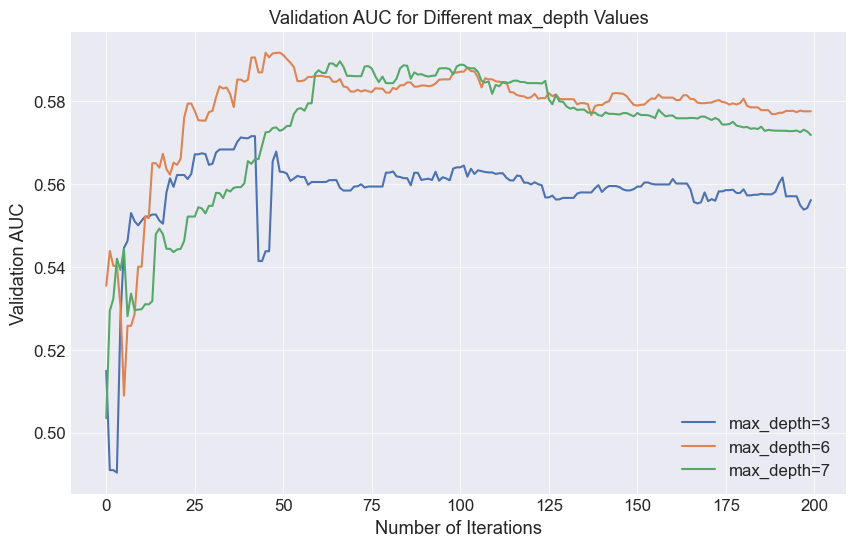

In [123]:
# plot results
plt.figure(figsize=(10, 6))
for max_depth, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=max_depth)

plt.xlabel('Number of Iterations')
plt.ylabel('Validation AUC')
plt.title('Validation AUC for Different max_depth Values')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
# max_depth=6 shows the best performance for the model. 
# - has the highest auc
# - converges faster
# - stable

# max_depth=3
# - low performance
# - underfitting

# max_depth=7
# - similar performance
# - longer to converge

# for bitcoin prediction, max_depth of 7 would be the best choice
# - fast convergence might miss subtle patterns
# - slower convergence could capture more complex market relationships

### Model Tuning: Min Child Weight

In [125]:
scores = {}
best_aucs = {}

In [126]:
%%capture output

for max_min_child_weight in [1, 3, 5, 7]:
    params = {
        'eta': 0.3,
        'max_depth': 7,
        'min_child_weight': max_min_child_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': 8,
        'random_state': 1,
        'verbosity': 1,
        'n_estimators': 200
    }
    
    # train model
    model, results = train_xgboost_model(X_train_selected, y_train, X_val_selected, y_val, params)
    
    # store results
    key = f'max_min_child_weight={max_min_child_weight}'
    scores[key] = parse_xgb_output(results)

    # store best aucs
    best_auc = max(results['validation_1']['auc'])
    best_aucs[max_min_child_weight] = best_auc


Best Performance:
max_min_child_weight=1 achieved highest validation AUC of 0.5897


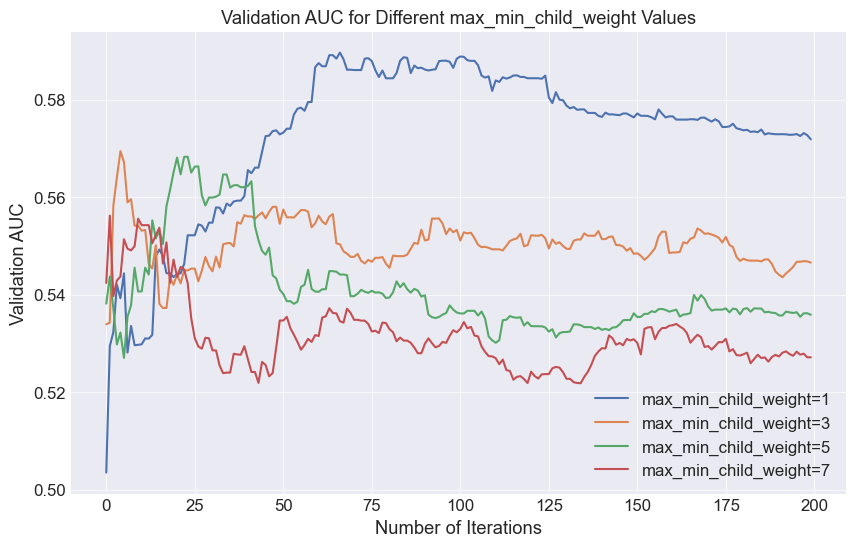

In [127]:
# Find the best performing max_depth
best_min_child_weight = max(best_aucs.items(), key=lambda x: x[1])
print("\nBest Performance:")
print(f"max_min_child_weight={best_min_child_weight[0]} achieved highest validation AUC of {best_min_child_weight[1]:.4f}")

# plot results
plt.figure(figsize=(10, 6))
for max_min_child_weight, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=max_min_child_weight)

plt.xlabel('Number of Iterations')
plt.ylabel('Validation AUC')
plt.title('Validation AUC for Different max_min_child_weight Values')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
# higher values than 1 seem to restrict the model too much

### Model Tuning: Sampling Parameters

In [129]:
scores = {}
best_aucs = {}

In [130]:
%%capture output

sampling_combinations = [
    # Aggressive sampling
    # # (0.6, 0.6),  # Very aggressive on both
    # # (0.6, 0.8),  # Aggressive rows, moderate features
    # (0.6, 1.0),  # Aggressive rows, all features
    
    # # Moderate sampling
    # # (0.8, 0.6),  # Moderate rows, aggressive features
    # # (0.8, 0.8),  # Moderate on both
    # (0.8, 1.0),  # Moderate rows, all features
    
    # # Conservative sampling
    # #(1.0, 0.6),  # All rows, aggressive features
    # (1.0, 0.8),  # All rows, moderate features
    (1.0, 1.0),  # No sampling (use all data)
    
    # Additional combinations
    # (0.7, 0.7),  # Slightly aggressive
    # (0.7, 0.9),  # Mix of aggressive and conservative
    # (0.9, 0.7),  # Conservative rows, aggressive features
    (0.9, 0.9),    # Very conservative
]

for sub, col in sampling_combinations:
    params = {
        'eta': 0.3,
        'max_depth': 7,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': 8,
        'random_state': 1,
        'verbosity': 1,
        'n_estimators': 200,
        'subsample': sub,
        'colsample_bytree': col
    }
    
    # Train model
    model, results = train_xgboost_model(X_train_selected, y_train, X_val_selected, y_val, params)
    
    # Store results using sub and col values in the key
    key = f'sub={sub}_col={col}'
    scores[key] = parse_xgb_output(results)

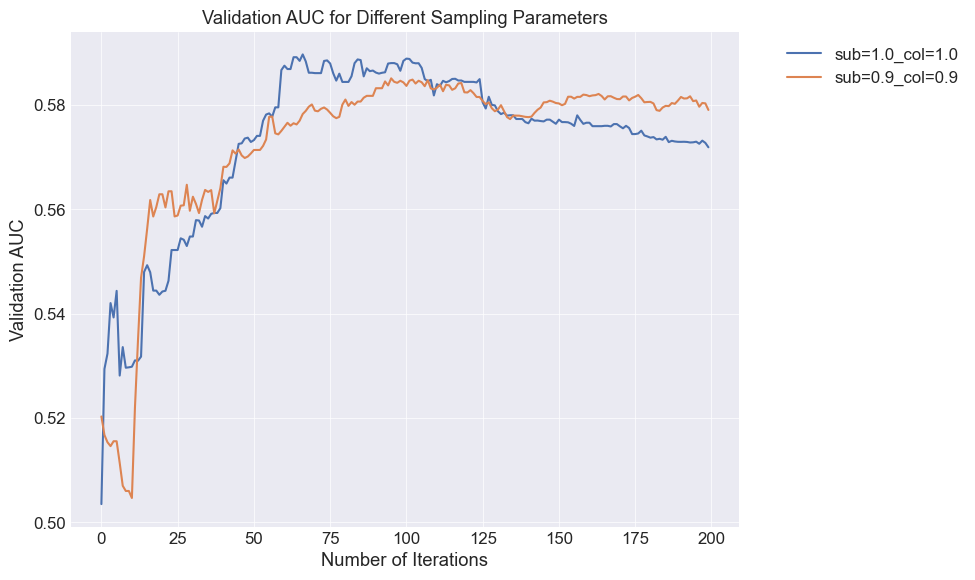

In [131]:
# plot results
plt.figure(figsize=(10, 6))
for sampling_params, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=sampling_params)

plt.xlabel('Number of Iterations')
plt.ylabel('Validation AUC')
plt.title('Validation AUC for Different Sampling Parameters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()  # Adjust layout to prevent legend cutoff
plt.grid(True)
plt.show()

In [132]:
print(f"Final Validation AUC with : {results['validation_1']['auc'][-1]:.3f}")

Final Validation AUC with : 0.579


### Model Tuning: Regularization

In [133]:
scores = {}
best_aucs = {}

In [134]:
%%capture output

# Define different combinations of regularization parameters to test
regularization_combinations = [
    {'alpha': 0, 'lambda': 1, 'gamma': 0}, 
    {'alpha': 0.8, 'lambda': 0.5, 'gamma': 0.02},
]

for reg_params in regularization_combinations:
    params = {
        'eta': 0.3,
        'max_depth': 7,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': 8,
        'random_state': 1,
        'verbosity': 1,
        'n_estimators': 500,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'alpha': reg_params['alpha'],
        'lambda': reg_params['lambda'],
        'gamma': reg_params['gamma']
    }
    
    # Train model
    model, results = train_xgboost_model(X_train_selected, y_train, X_val_selected, y_val, params)
    
    # Store results with descriptive key
    key = f"α={reg_params['alpha']},λ={reg_params['lambda']},γ={reg_params['gamma']}"
    scores[key] = parse_xgb_output(results)

    best_auc = max(results['validation_1']['auc'])
    best_aucs[tuple(reg_params.items())] = best_auc 

In [135]:
best_reg_params = max(best_aucs.items(), key=lambda x: x[1])
print("\nBest Performance:")
print(f"max_reg_parms={best_reg_params[0]} achieved highest validation AUC of {best_reg_params[1]:.4f}")


Best Performance:
max_reg_parms=(('alpha', 0), ('lambda', 1), ('gamma', 0)) achieved highest validation AUC of 0.5851


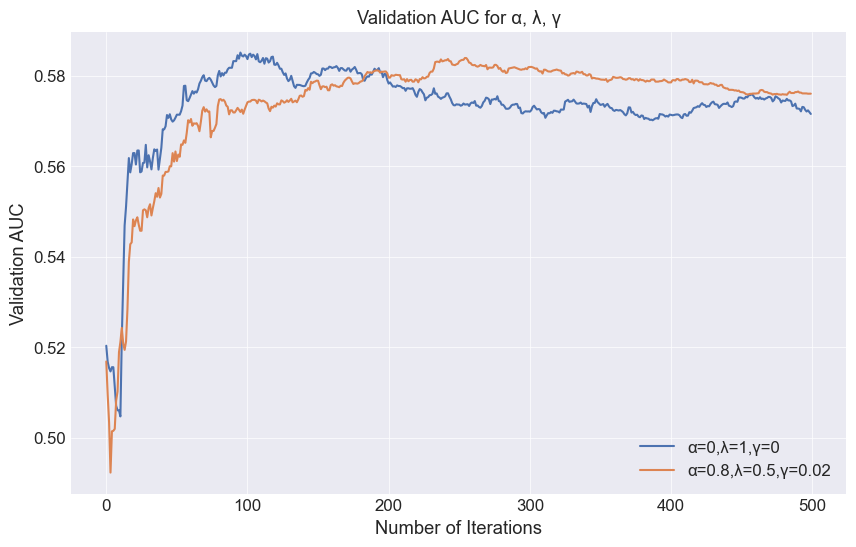

In [136]:
# plot results
plt.figure(figsize=(10, 6))
for max_min_child_weight, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label=max_min_child_weight)

plt.xlabel('Number of Iterations')
plt.ylabel('Validation AUC')
plt.title('Validation AUC for α, λ, γ')
plt.legend()
plt.grid(True)
plt.show()

In [137]:
# in this result, the orange line shows mroe stability, indicating less fluctuation in performance
# the orange line maintains a higher auc score for longer periods. which suggests better generalization

### Final Evaluation Model in Comparison with Training Set

In [138]:
%%capture output

params = {
    'eta': 0.3,
    'max_depth': 7,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_jobs': 8,
    'random_state': 1,
    'verbosity': 1,
    'n_estimators': 500,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'alpha': 0.8,
    'lambda': 0.5,
    'gamma': 0.02,
    'early_stopping_rounds': 55
}

# Train model
model, results = train_xgboost_model(X_train_selected, y_train, X_val_selected, y_val, params)

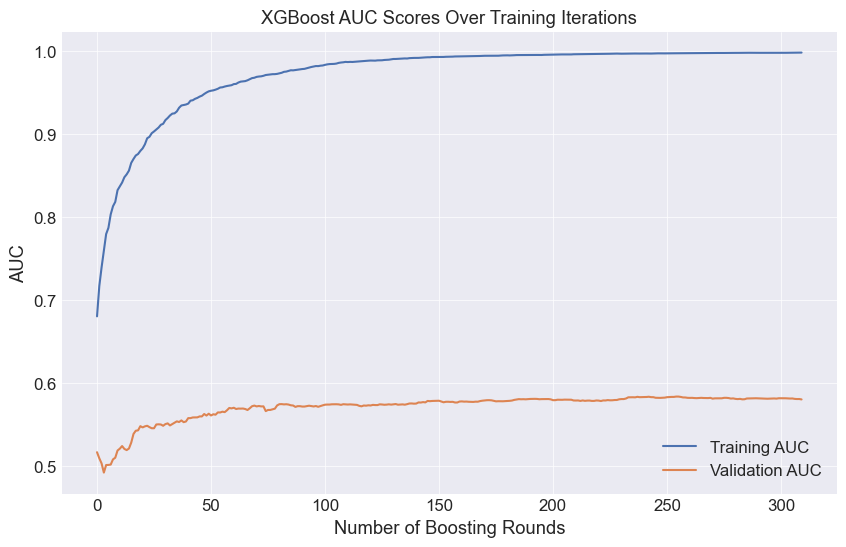

Final Highest Training AUC: 0.999
Final Highest Validation AUC: 0.584
Final gap: 0.4181


In [139]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['auc'], label='Training AUC')
plt.plot(results['validation_1']['auc'], label='Validation AUC')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('AUC')
plt.title('XGBoost AUC Scores Over Training Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Print final scores
print(f"Final Highest Training AUC: {max(results['validation_0']['auc']):.3f}")
print(f"Final Highest Validation AUC: {max(results['validation_1']['auc']):.3f}")

# Gap between training and validation
train_auc = results['validation_0']['auc'][-1]
val_auc = results['validation_1']['auc'][-1]
print(f"Final gap: {train_auc - val_auc:.4f}")

### Evaluate on the test set

In [140]:
y_pred = model.predict_proba(X_test[selected_features])[:,1]
auc_score = roc_auc_score(y_test, y_pred)
print(f'XGBoost: AUC Score={auc_score:.3f}')

XGBoost: AUC Score=0.529


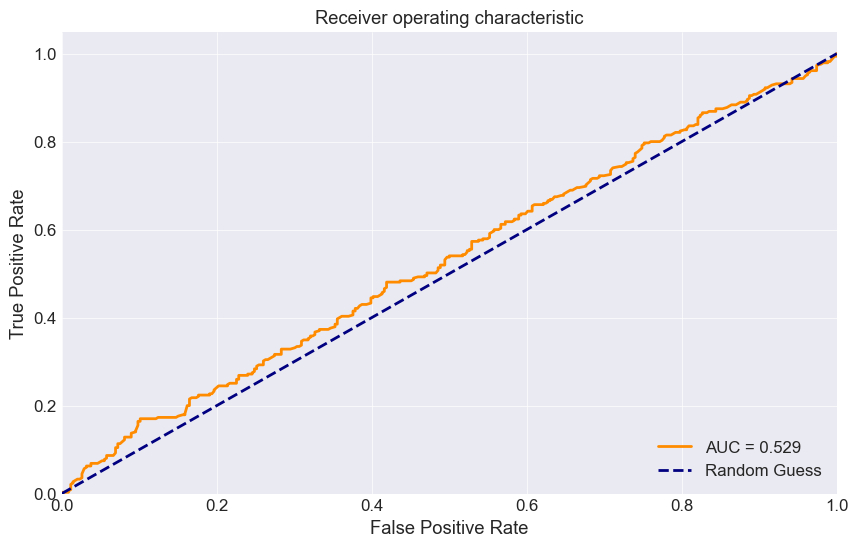

In [141]:
from sklearn.metrics import roc_curve, auc

# Plotting AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.style.use('seaborn-v0_8-dark')
plt.grid(True)
plt.show()

In [142]:
print(X_train_full.shape, X_test_full.shape)
print(y_train_full.shape, y_test_full.shape)

(2690, 34) (681, 34)
(2690,) (681,)


In [143]:
%%capture output

params = {
    'eta': 0.3,
    'max_depth': 7,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_jobs': 8,
    'random_state': 1,
    'verbosity': 1,
    'n_estimators': 500,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'alpha': 0.8,
    'lambda': 0.5,
    'gamma': 0.02,
    'early_stopping_rounds': 55
}

model = xgb_model.fit(
    X_train_full[selected_features], 
    y_train_full
)


In [144]:
y_pred = model.predict_proba(X_test_full[selected_features])[:,1]
auc_score = roc_auc_score(y_test_full, y_pred)
print(f'XGBoost: AUC Score={auc_score:.3f}')

XGBoost: AUC Score=0.525


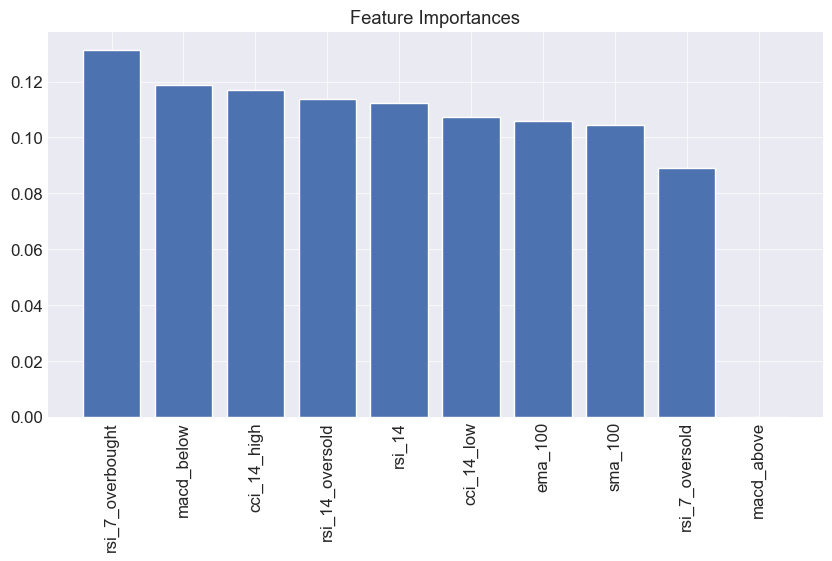

In [145]:
# Plotting Feature Importances 
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(len(selected_features)), importances[indices])
plt.xticks(range(len(selected_features)), [selected_features[i] for i in indices], rotation=90)
plt.grid(True)
plt.show()

### Create a Quantile Analysis and Trading Signal Generation

In [146]:
# First ensure X_test_full and y_test_full have the same index
X_test_subset = X_test_full[selected_features].copy()
y_test_aligned = y_test_full[X_test_full.index]

# Get predictions
y_pred = model.predict_proba(X_test_subset)[:,1]

# Add y_true column to the subset
X_test_subset['y_true'] = y_test_aligned

# Create quantile analysis
quantile_intervals = np.arange(0, 1.125, 0.125) # Creating intervals for the quantiles 
quantile_values = np.quantile(y_pred, quantile_intervals) # Dividing y_pred in 8 different quantiles
classes = pd.cut(y_pred, quantile_values) # Grouping probabilities according to the quantiles 

# Create crosstab
table = pd.crosstab(classes, X_test_subset['y_true'])
table


y_true,0,1
row_0,,
"(0.0388, 0.255]",42,43
"(0.255, 0.35]",47,38
"(0.35, 0.437]",42,43
"(0.437, 0.518]",50,35
"(0.518, 0.591]",39,46
"(0.591, 0.686]",48,37
"(0.686, 0.799]",44,41
"(0.799, 0.96]",33,52


### Generate signals based on ranges

To represent bearish ranges, I will assign the value of -1, while for bullish ranges, I will assign the value of 1.

In [147]:
sign = np.zeros_like(y_pred) # Creating an array with 0s in the same length as y_pred

# Short selling signal 
sign[((y_pred > 0.255) & (y_pred <= 0.35) | 
      (y_pred > 0.437) & (y_pred <= 0.518)) | 
      ((y_pred > 0.591) & (y_pred <= 0.686)) | 
      ((y_pred > 0.686) & (y_pred <= 0.799))] = 0

# Buying signal 
sign[((y_pred > 0.0388) & (y_pred <= 0.255)) | 
     ((y_pred > 0.35) & (y_pred <= 0.437)) | 
     ((y_pred > 0.518) & (y_pred <= 0.591)) | 
     (y_pred > 0.799) & (y_pred <= 0.96)] = 1

sign

array([1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1.

In [148]:
len(sign)

681

In [150]:
X_test_full.head()

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,...,cci_14_low,macd_signal,macd_diff,macd_above,macd_below,macd_cross_above,macd_cross_below,prev_close,return,sign
date,,,,,,,,,,,,,,,,,,,,,
2022-06-19,19010.902344,20683.822266,18067.152344,20553.271484,3.532994e+10,27.445747,28.387883,-82.863194,-89.269036,29747.012656,...,0,-2147.619081,-793.697470,0,1,False,False,19017.642578,8.074760,1.0
2022-06-20,20553.371094,20913.322266,19689.169922,20599.537109,3.081846e+10,27.917957,28.625903,-25.849484,-69.795117,29389.621523,...,0,-2308.265616,-642.586140,0,1,False,False,20553.271484,0.225101,1.0
2022-06-21,20594.294922,21620.628906,20415.062500,20710.597656,2.897021e+10,29.208293,29.233951,35.832109,-54.854414,29033.246914,...,0,-2429.779471,-486.055417,0,1,False,False,20599.537109,0.539141,1.0
2022-06-22,20719.414063,20835.750000,19848.078125,19987.029297,2.857479e+10,25.710083,27.585119,-13.523546,-61.150539,28677.978438,...,0,-2526.401913,-386.489771,0,1,False,False,20710.597656,-3.493711,0.0
2022-06-23,19986.607422,21135.761719,19950.117188,21085.876953,2.618810e+10,38.714779,33.700735,64.512609,-45.817986,28305.728555,...,0,-2579.068140,-210.664906,0,1,False,False,19987.029297,5.497804,1.0


In [151]:
X_test_full['position'] = X_test_full['sign'].shift(1)
X_test_full['model_returns'] = X_test_full['position'] * X_test_full['return']

In [152]:
X_test_full.head()

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,...,macd_diff,macd_above,macd_below,macd_cross_above,macd_cross_below,prev_close,return,sign,position,model_returns
date,,,,,,,,,,,,,,,,,,,,,
2022-06-19,19010.902344,20683.822266,18067.152344,20553.271484,3.532994e+10,27.445747,28.387883,-82.863194,-89.269036,29747.012656,...,-793.697470,0,1,False,False,19017.642578,8.074760,1.0,NaN,NaN
2022-06-20,20553.371094,20913.322266,19689.169922,20599.537109,3.081846e+10,27.917957,28.625903,-25.849484,-69.795117,29389.621523,...,-642.586140,0,1,False,False,20553.271484,0.225101,1.0,1.0,0.225101
2022-06-21,20594.294922,21620.628906,20415.062500,20710.597656,2.897021e+10,29.208293,29.233951,35.832109,-54.854414,29033.246914,...,-486.055417,0,1,False,False,20599.537109,0.539141,1.0,1.0,0.539141
2022-06-22,20719.414063,20835.750000,19848.078125,19987.029297,2.857479e+10,25.710083,27.585119,-13.523546,-61.150539,28677.978438,...,-386.489771,0,1,False,False,20710.597656,-3.493711,0.0,1.0,-3.493711
2022-06-23,19986.607422,21135.761719,19950.117188,21085.876953,2.618810e+10,38.714779,33.700735,64.512609,-45.817986,28305.728555,...,-210.664906,0,1,False,False,19987.029297,5.497804,1.0,0.0,0.000000


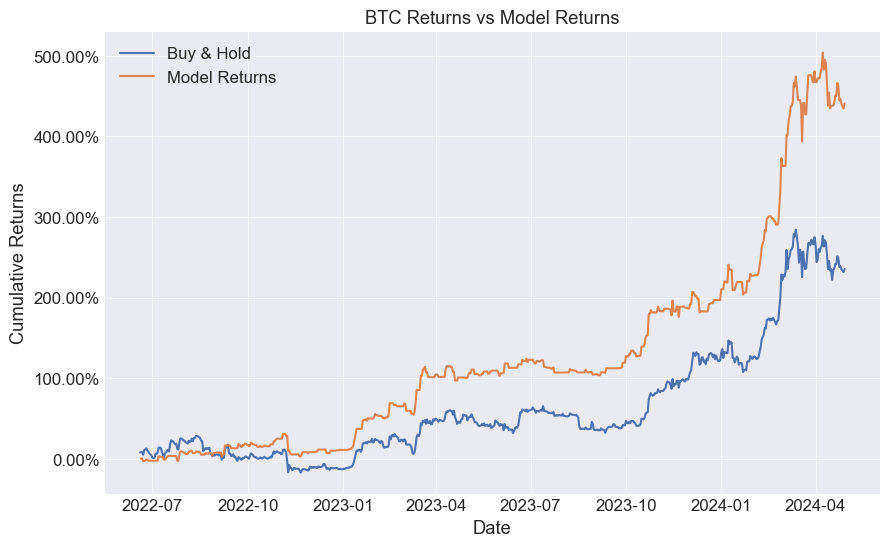


 Buy & Hold Cumulative Returns = 235.69% 
 Model Cumulative Returns = 440.95%


In [153]:
# Computing Bitcoin's cumulative returns
buy_and_hold_total_returns = (1 + X_test_full['return'] / 100).cumprod()
buy_and_hold_total_returns = (buy_and_hold_total_returns - 1) * 100

# Computing model's cumulative returns
model_cumulative_returns = (1 + X_test_full['model_returns'] / 100).cumprod()
model_cumulative_returns = (model_cumulative_returns - 1) * 100

# Plotting line plot comparing Buy & Hold and Model 
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(buy_and_hold_total_returns, label = 'Buy & Hold')
ax.plot(model_cumulative_returns, label = 'Model Returns')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.set_title('BTC Returns vs Model Returns')

# Adding a '%' sign to the y-axis ticks 
def percent_formatter(x, pos):
    return f'{x:.2f}%'
ax.yaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))

plt.style.use('seaborn-v0_8-dark')
plt.grid(True)
plt.show()

# Printing results
print(f'\n Buy & Hold Cumulative Returns = {buy_and_hold_total_returns.iloc[-1]:.2f}% \n Model Cumulative Returns = {model_cumulative_returns.iloc[-1]:.2f}%')

### BTC Returns vs Model Returns

The chart above compares the cumulative returns of a "Buy & Hold" strategy versus a machine learning model's trading strategy for Bitcoin (BTC) from mid-2022 to mid-2024.

Buy & Hold Strategy: This approach involves purchasing BTC at the start of the period and holding it throughout. The cumulative returns for this strategy reached approximately 235.69%.

Model Returns: The machine learning model, trained to predict BTC price movements, generated trading signals that resulted in cumulative returns of about 440.95%. The model's strategy significantly outperformed the Buy & Hold approach, particularly noticeable in the latter half of the period.

The model's ability to adapt to market conditions and make informed trading decisions contributed to its superior performance. The chart visually demonstrates the model's effectiveness in capturing upward trends and mitigating losses during downturns.

### Further comparison

In [154]:
# Convert returns to decimal values and ensure proper datetime index
model_returns = pd.Series(X_test_full['model_returns'] / 100, index=pd.to_datetime(X_test_full.index))
btc_returns = pd.Series(X_test_full['return'] / 100, index=pd.to_datetime(X_test_full.index))

# Calculate key performance metrics
print("Model Performance Metrics:")
print("-" * 25)
print(f"Cumulative Return: {(np.exp(np.log1p(model_returns).sum()) - 1):.2%}")
print(f"Annual Return: {qs.stats.cagr(model_returns):.2%}")
print(f"Sharpe Ratio: {qs.stats.sharpe(model_returns):.2f}")
print(f"Max Drawdown: {qs.stats.max_drawdown(model_returns):.2%}")
print(f"Win Rate: {qs.stats.win_rate(model_returns):.2%}")
print(f"Volatility (ann.): {qs.stats.volatility(model_returns, annualize=True):.2%}")

print("\nBTC (Buy & Hold) Performance Metrics:")
print("-" * 25)
print(f"Cumulative Return: {(np.exp(np.log1p(btc_returns).sum()) - 1):.2%}")
print(f"Annual Return: {qs.stats.cagr(btc_returns):.2%}")
print(f"Sharpe Ratio: {qs.stats.sharpe(btc_returns):.2f}")
print(f"Max Drawdown: {qs.stats.max_drawdown(btc_returns):.2%}")
print(f"Win Rate: {qs.stats.win_rate(btc_returns):.2%}")
print(f"Volatility (ann.): {qs.stats.volatility(btc_returns, annualize=True):.2%}")

# Calculate Information Ratio
excess_returns = model_returns - btc_returns
information_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
print("\nComparative Metrics:")
print("-" * 25)
print(f"Information Ratio: {information_ratio:.2f}")

Model Performance Metrics:
-------------------------
Cumulative Return: 440.95%
Annual Return: 86.94%
Sharpe Ratio: 2.11
Max Drawdown: -21.27%
Win Rate: 54.71%
Volatility (ann.): 31.97%

BTC (Buy & Hold) Performance Metrics:
-------------------------
Cumulative Return: 235.69%
Annual Return: 56.64%
Sharpe Ratio: 1.28
Max Drawdown: -35.36%
Win Rate: 49.34%
Volatility (ann.): 41.89%

Comparative Metrics:
-------------------------
Information Ratio: 0.64
